In [3]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50 #trial and error
CHANNELS = 3

**Tomato Leaf Diseases Classification Using CNN Architecture**

In [6]:
#Generates a tf.data.Dataset from image files in a directory.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillageTomato",
     batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

Found 16011 files belonging to 10 classes.


**There are 10 different classes of the tomato leaf** 

In [8]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    print(label_batch[0].numpy())

[[[127. 122. 145.]
  [113. 108. 131.]
  [107. 102. 125.]
  ...
  [122. 118. 145.]
  [108. 104. 131.]
  [138. 134. 161.]]

 [[110. 105. 128.]
  [ 98.  93. 116.]
  [ 99.  94. 117.]
  ...
  [140. 136. 163.]
  [118. 114. 141.]
  [137. 133. 160.]]

 [[113. 108. 131.]
  [ 99.  94. 117.]
  [104.  99. 122.]
  ...
  [147. 143. 170.]
  [125. 121. 148.]
  [133. 129. 156.]]

 ...

 [[121. 121. 147.]
  [135. 135. 161.]
  [112. 112. 138.]
  ...
  [148. 151. 182.]
  [144. 147. 178.]
  [137. 140. 171.]]

 [[104. 104. 130.]
  [109. 109. 135.]
  [126. 126. 152.]
  ...
  [154. 157. 188.]
  [148. 151. 182.]
  [136. 139. 170.]]

 [[125. 125. 151.]
  [102. 102. 128.]
  [136. 136. 162.]
  ...
  [136. 139. 170.]
  [145. 148. 179.]
  [152. 155. 186.]]]
4


In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 8 4 7 5 3 2 9 2 6 4 7 0 5 0 0 7 7 2 3 8 9 3 1 6 4 2 2 5 6 0 7]


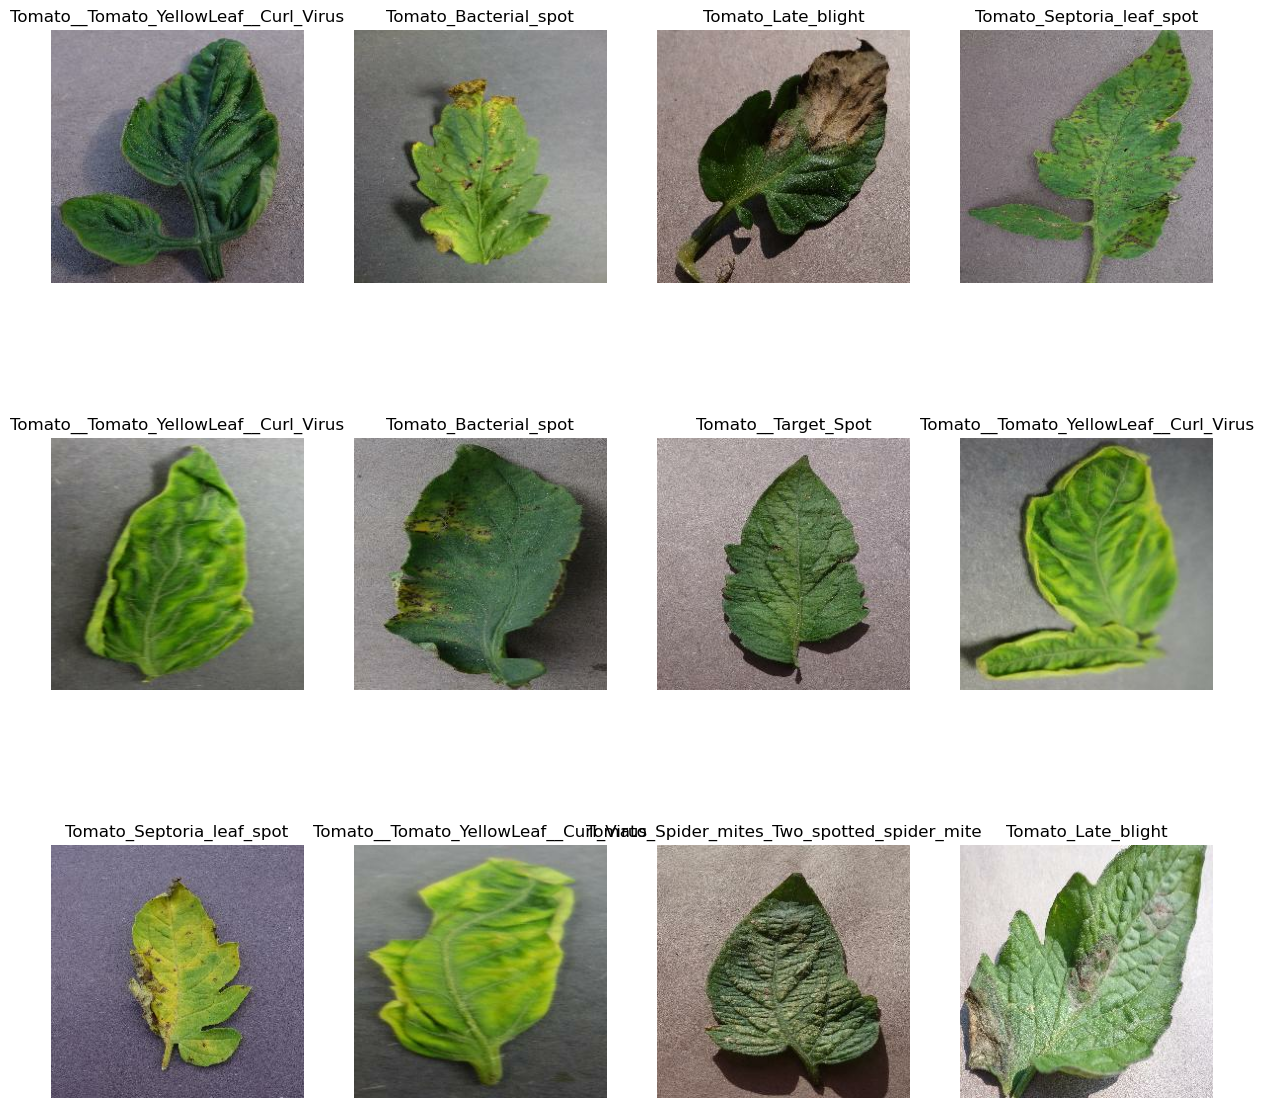

In [11]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [14]:
def get_dataset_partition_tf(ds, train_split = 0.8,val_split = 0.1,test_split=0.1, shuffle = True, shuffle_size = 10000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
        
    train_size= int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds, val_ds, test_ds
    

In [21]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [23]:
len(dataset)

501

In [25]:
print("train dataset length:",len(train_ds))
print("validation dataset length:",len(val_ds))
print("test dataset length:",len(test_ds))

train dataset length: 400
validation dataset length: 50
test dataset length: 51


**These operations are intended to optimize the performance of the data pipeline, ensuring efficient data loading and processing during model training and evaluation.**

In [28]:
"""

cache()
Purpose:
Caches the dataset in memory or on disk after the first iteration, making subsequent epochs much faster.
It avoids re-reading or re-processing the data from the original source, reducing the overhead.
Usage:
This is particularly useful when your dataset fits into memory and doesn't change between epochs. If your dataset is large, 
you can cache it to disk to still benefit from this speed-up.
-------------
Why shuffle again?
-Ensures that batches are not fed in the same order across different epochs. Re-shuffling the dataset at each epoch prevents 
the model from learning the order of the data, which can lead to better generalization.

The result is that each time the dataset is iterated over (such as during each epoch), 
the files will appear in a different order, preventing the model from learning any particular sequence of data.
-------------

prefetch(buffer_size=tf.data.AUTOTUNE)
Purpose:
Prefetches batches of data in the background while the model is training on the current batch. This overlaps the data preparation with the model's 
training, reducing the overall training time.
tf.data.AUTOTUNE:
TensorFlow automatically determines the optimal number of batches to prefetch based on the available system resources (like CPU, GPU, and memory).
This ensures efficient pipeline operation without requiring manual tuning.

"""

train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [30]:
resize_and_rescale = tf.keras.Sequential([
   layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
   layers.experimental.preprocessing.Rescaling(1.0/255) 
])

In [32]:
data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), #A preprocessing layer which randomly flips images during training.
      layers.experimental.preprocessing.RandomRotation(0.2),
])

**Convolutional Neural Network**

In [35]:
#Covolutional and pooling layers, and at the end dense layer
#Model
#preprocessing layers: resize and rescale then data augmentation
#convolution layer--> arguments: no. of filters , size of kernel, activation layer, input shape
#Pooling--> max pooling, avg. pooling: preserve features and reduce image size(computationaly efficient)

#You can stack multiple conv and pooling layers(trial and error)
n_classes = 10
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #layer 1 , conv+pooling
    layers.Conv2D(32, (3,3) ,activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
     #layer 2 , conv+pooling
    layers.Conv2D(64, kernel_size = (3,3) ,activation='relu'),
    layers.MaxPooling2D((2,2)),
    #layer 3 , conv+pooling    
    layers.Conv2D(64, kernel_size = (3,3) ,activation='relu'),
    layers.MaxPooling2D((2,2)),
     #layer 4 , conv+pooling 
    layers.Conv2D(64, kernel_size = (3,3) ,activation='relu'),
    layers.MaxPooling2D((2,2)),
    #layer 5 , conv+pooling
    layers.Conv2D(64, kernel_size = (3,3) ,activation='relu'),
    layers.MaxPooling2D((2,2)),
     #layer 6 , conv+pooling
    layers.Conv2D(64, kernel_size = (3,3) ,activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    #Dense layer then output layer
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)


In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [39]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
)

In [ ]:
history = model.fit(
          train_ds,
          epochs = EPOCHS,
          verbose = 1,
          validation_data = val_ds, 
         )

Epoch 1/50


